In [51]:
# Activate your environment
import Pkg
Pkg.activate("../KellyEnv")

  Activating project at `c:\Users\Zahnbuerste_HQ\Documents\AA_Studium\Master\05_Masterarbeit\Playground\VS_refactor\KellyEnv`


In [52]:
using UnfoldSim
using Unfold
using StableRNGs
using SequentialSamplingModels
using CairoMakie, UnfoldMakie

In [53]:
include(joinpath(pathof(Unfold),"..","eventhandling.jl"))

copy_eventinfo!

In [54]:
using Statistics
function add_rt_to_events_and_slow_flag(evts)
    original_onsets = diff(evts.latency; dims=1)
    original_onsets = vcat(original_onsets, 600)
    evts.rt = original_onsets
    # Add slow_response flag
    mask = evts.event .== 'C'
    # Calculate the median only for the rows where the mask is true
    filtered_rt = evts.rt[mask]  
    med_rt = median(filtered_rt)
    # Initialize slow_response column with false
    evts.slow_response = falses(size(evts.rt))
    # Apply the condition only to the masked rows
    evts.slow_response[mask] .= filtered_rt .> med_rt
    return evts
end

add_rt_to_events_and_slow_flag (generic function with 1 method)

# Setup

In [90]:
fs = 500
Δt = 1/fs; # time step
tEnd = 1.0 # trial Duration
time_vec = 0:Δt:tEnd; # time base - let's make it a typical stimulus duration
# :drift_rate => [5.45, 7.8]  :drift_rate => [[0.45], [0.8], :drift_rate => [[0.65], [1.0]]


design_single = SingleSubjectDesign(
    conditions = Dict(:drift_rate => [0.45, 0.8], :condition => [1])
    )
design_seq = SequenceDesign(design_single, "SCR")
design_rep = RepeatDesign(design_seq, 100)


RepeatDesign{SequenceDesign{SingleSubjectDesign}}
  design: SequenceDesign{SingleSubjectDesign}
  repeat: Int64 100


In [56]:
generate_events(design_seq)

Row,drift_rate,condition,event
,Float64,Int64,Char
1,5.45,1,S
2,5.45,1,C
3,5.45,1,R
4,7.8,1,S
5,7.8,1,C
6,7.8,1,R


# Components

In [57]:
comp_length=1.0
stim = LinearModelComponent(;
    basis = UnfoldSim.hanning(Int(comp_length * fs)),
    formula = @formula(0 ~ 1 + condition),
    β = [0.5, 0],
)
resp = LinearModelComponent(;
    basis = UnfoldSim.hanning(Int(comp_length * fs)),
    formula = @formula(0 ~ 1 + condition),
    β = [-0.5, 0],
)

LinearModelComponent
  basis: Array{Float64}((500,)) [0.0, 3.963628259290308e-5, 0.00015853884623195924, 0.0003566888394948009, 0.0006340548466648444, 0.0009905928927123608, 0.0014262464502663441, 0.0019409464485766748, 0.0025346112844650825, 0.003207146835262742  …  0.003207146835262742, 0.0025346112844650825, 0.0019409464485766748, 0.0014262464502663441, 0.0009905928927123608, 0.0006340548466648444, 0.0003566888394948009, 0.00015853884623195924, 3.963628259290308e-5, 0.0]
  formula: StatsModels.FormulaTerm{StatsModels.ConstantTerm{Int64}, Tuple{StatsModels.ConstantTerm{Int64}, StatsModels.Term}}
  β: Array{Float64}((2,)) [-0.5, 0.0]
  contrasts: Dict{Any, Any}
  offset: Int64 0


## DDM

In [91]:
v = "drift_rate" # Drift Rate
a = 2.0 # The amount of information that is considered for a decision.
t = 0.30 # The duration for a non-decisional processes (encoding and response execution).
z = 0.50 # An indicator of an an initial bias towards a decision.
model_parameter = Dict(:ν=>"drift_rate", :α=>4, :z=>0.5, :τ=>0.2)

drift = DriftComponent(501,fs,DDM,model_parameter)

DriftComponent(501, 500, DDM, Dict{Symbol, Any}(:α => 4, :ν => "drift_rate", :τ => 0.2, :z => 0.5))

## LBA

In [74]:
model_parameter = Dict(:ν=>"drift_rate", :A=>0.01, :k=>0.6, :τ=>0.4, :σ=>0)

drift = DriftComponent(501,fs,LBA,model_parameter)

DriftComponent(501, 500, LBA, Dict{Symbol, Any}(:ν => "drift_rate", :σ => 0, :A => 0.01, :k => 0.6, :τ => 0.4))

## Kelly Model

In [102]:
kelly_model_parameter = Dict(:drift_rate => "drift_rate")

drift = DriftComponent(501,fs,KellyModel,kelly_model_parameter)

DriftComponent(501, 500, KellyModel, Dict(:drift_rate => "drift_rate"))

In [104]:
components = Dict(
    'S' => [stim],
    'C' => [drift],
    'R' => [resp]
    )

Dict{Char, Vector} with 3 entries:
  'R' => LinearModelComponent[LinearModelComponent([0.0, 3.96363e-5, 0.00015853…
  'S' => LinearModelComponent[LinearModelComponent([0.0, 3.96363e-5, 0.00015853…
  'C' => DriftComponent[DriftComponent(501, 500, KellyModel, Dict(:drift_rate=>…

# Onset

In [105]:
fs = 500
component_length = 1.0
seq_onset = SequenceOnset(
    Dict('S'=> UniformOnset(width=0, offset=(comp_length*fs*1.2)),
         'C'=> DriftOnset(),
         'R'=> UniformOnset(width=0, offset=(comp_length*fs*1.5)))
    )

SequenceOnset(Dict{Char, AbstractOnset}('R' => UniformOnset
  width: Int64 0
  offset: Float64 750.0
, 'S' => UniformOnset
  width: Int64 0
  offset: Float64 600.0
, 'C' => DriftOnset{UniformOnset}(UniformOnset
  width: Int64 0
  offset: Int64 0
)))

# Simulation

In [110]:
data, events = UnfoldSim.simulate(
    StableRNG(12),
    design_rep,
    components,
    seq_onset,
    NoNoise()
)


 # PinkNoise(noiselevel=1)# 
evts = add_rt_to_events_and_slow_flag(evts)

Row,drift_rate,condition,event,latency,rt,slow_response
,Float64,Int64,Char,Any,Int64,Bool
1,0.45,1,S,751,600,false
2,0.45,1,C,1351,680,false
3,0.45,1,R,2031,750,false
4,0.8,1,S,2781,600,false
5,0.8,1,C,3381,725,true
6,0.8,1,R,4106,750,false
7,0.45,1,S,4856,600,false
8,0.45,1,C,5456,583,false
9,0.45,1,R,6039,750,false


In [111]:
evts2  = deepcopy(evts)
evts2.trial_type = evts2.event
copy_eventinfo!(evts2,'C'=>'S',"slow_response";match_fun="s after t")
copy_eventinfo!(evts2,'C'=>'R',"slow_response";match_fun="s before t")

Row,drift_rate,condition,event,latency,rt,slow_response,trial_type
,Float64,Int64,Char,Any,Int64,Bool,Char
1,0.45,1,S,751,600,false,S
2,0.45,1,C,1351,680,false,C
3,0.45,1,R,2031,750,false,R
4,0.8,1,S,2781,600,true,S
5,0.8,1,C,3381,725,true,C
6,0.8,1,R,4106,750,true,R
7,0.45,1,S,4856,600,false,S
8,0.45,1,C,5456,583,false,C
9,0.45,1,R,6039,750,false,R


# Plots

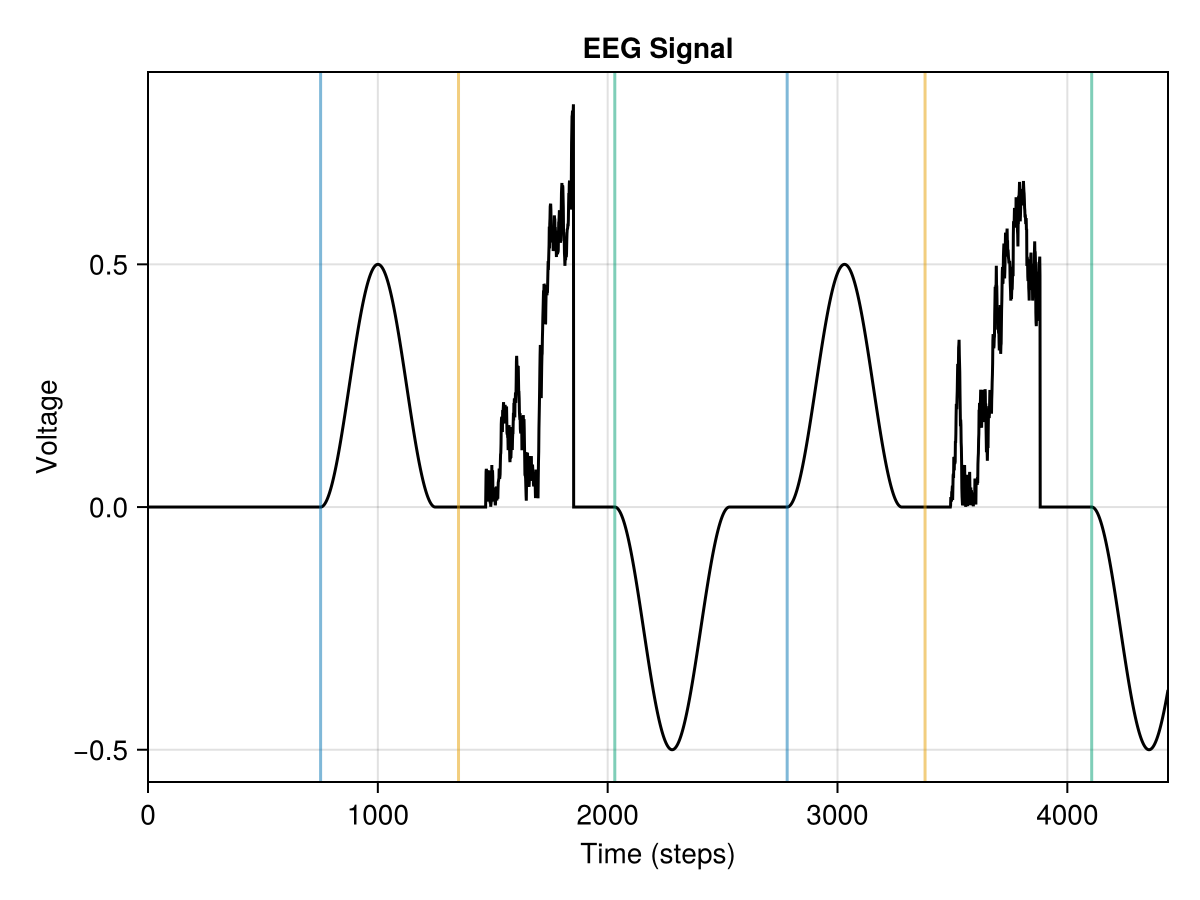

CairoMakie.Screen{IMAGE}


In [112]:
fig = Figure()
ax = Axis(fig[1, 1], xlabel="Time (steps)", ylabel="Voltage", title="EEG Signal")
#ax.yticks = -0.6:0.2:0.6
lines!(data[1:4438], color=(:black, 1))
evts_limited = deepcopy(evts)[1:6, :]
CairoMakie.xlims!(0, 4438)
vlines!(evts_limited.latency[evts_limited.event.=='S'], color = (Makie.wong_colors()[1], 0.5))
vlines!(evts_limited.latency[evts_limited.event.=='C'], color = (Makie.wong_colors()[2], 0.5))
vlines!(evts_limited.latency[evts_limited.event.=='R'], color = (Makie.wong_colors()[3], 0.5))
#current_figure()
# Display the plot
display(fig)

(isnothing(evts), isnothing(tbl)) = (false, false)


┌ Warning: Missings in data - we remove any trial from data and designmatrix
└ @ Unfold C:\Users\Zahnbuerste_HQ\.julia\packages\Unfold\5pvbP\src\solver\prepare.jl:19
┌ Warning: Missings in data - we remove any trial from data and designmatrix
└ @ Unfold C:\Users\Zahnbuerste_HQ\.julia\packages\Unfold\5pvbP\src\solver\prepare.jl:19
┌ Warning: Missings in data - we remove any trial from data and designmatrix
└ @ Unfold C:\Users\Zahnbuerste_HQ\.julia\packages\Unfold\5pvbP\src\solver\prepare.jl:19


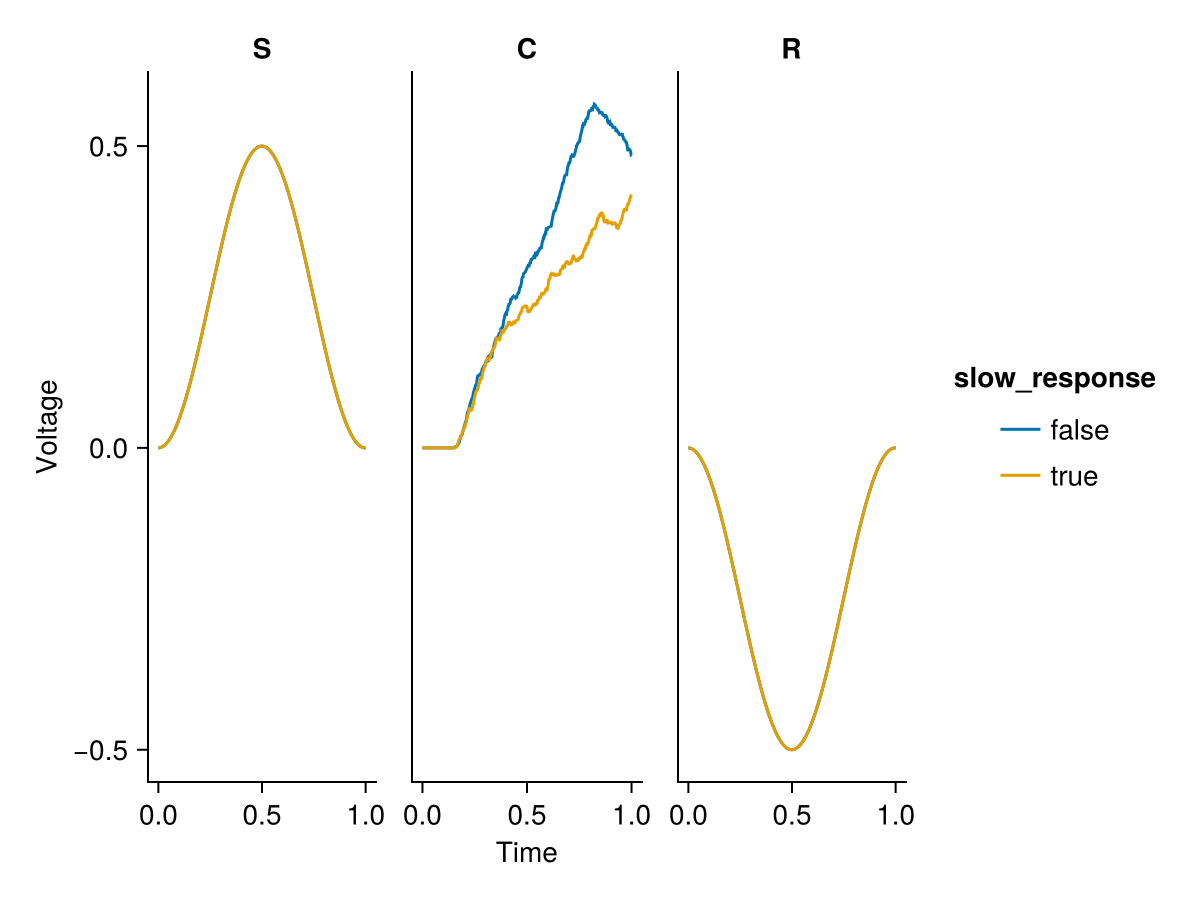

In [113]:
# ## Plot ERP of simulated EEG
evts.event = string.(evts.event)
data_epochs, times_epoch = Unfold.epoch(data = data, tbl = evts, τ = (-0.0, 1.0), sfreq = fs);
f = @formula(0 ~ 1 + slow_response)
m = fit(UnfoldModel, ["S"=>(f,times_epoch),"R"=>(f,times_epoch),"C"=>(f,times_epoch)], evts, data_epochs);
#results = coeftable(m)
eff = effects(Dict(:slow_response => [false, true]), m)
# Plot Result
eff.slow_response = string.(eff.slow_response)
plot_erp(eff;mapping=(;col=:eventname=>UnfoldMakie.AlgebraOfGraphics.sorter(["S","C","R"]), color=:slow_response))